In [2]:
import pandas as pd
import os

data_dir = './Dataset/Equities'

stock_data = {}
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        stock_name = file.split('.')[0]
        file_path = os.path.join(data_dir, file)
        stock_data[stock_name] = pd.read_csv(file_path)

for stock, data in stock_data.items():
    print(f"{stock} Data:")
    print(data.head())

BA Data:
         Date        Open        High         Low       Close   Adj Close  \
0  2014-05-27  133.089996  134.210007  132.869995  134.169998  115.965096   
1  2014-05-28  134.169998  135.149994  134.169998  134.330002  116.103371   
2  2014-05-29  134.710007  135.199997  134.429993  135.139999  116.803482   
3  2014-05-30  134.669998  135.440002  134.039993  135.250000  116.898544   
4  2014-06-02  135.500000  136.029999  134.770004  135.899994  117.460373   

    Volume  
0  3085500  
1  2609400  
2  2234100  
3  2760300  
4  2629900  
MSBHF Data:
         Date      Open      High       Low     Close  Adj Close  Volume
0  2014-05-27  6.466667  6.466667  6.466667  6.466667   4.680295       0
1  2014-05-28  6.466667  6.466667  6.466667  6.466667   4.680295       0
2  2014-05-29  6.466667  6.466667  6.466667  6.466667   4.680295       0
3  2014-05-30  6.466667  6.466667  6.466667  6.466667   4.680295       0
4  2014-06-02  6.466667  6.466667  6.466667  6.466667   4.680295       0


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df):
    df = df.dropna()

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return scaled_df, scaler

preprocessed_data = {}
scalers = {}
for stock, data in stock_data.items():
    preprocessed_data[stock], scalers[stock] = preprocess_data(data)

for stock, data in preprocessed_data.items():
    print(f"{stock} Preprocessed Data:")
    print(data.head())

BA Preprocessed Data:
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2014-05-27  0.098888  0.089476  0.124918  0.113307   0.062498  0.022423
2014-05-28  0.101998  0.092221  0.128620  0.113770   0.062911  0.017774
2014-05-29  0.103554  0.092367  0.129360  0.116114   0.064999  0.014110
2014-05-30  0.103438  0.093067  0.128250  0.116432   0.065282  0.019247
2014-06-02  0.105828  0.094790  0.130328  0.118313   0.066958  0.017974
MSBHF Preprocessed Data:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2014-05-27  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-05-28  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-05-29  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-05-30  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-06-02  0.090584  0.08944

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_sequences(data, seq_length=60):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i+seq_length].values)
        labels.append(data['Close'].iloc[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X, y = {}, {}
for stock, data in preprocessed_data.items():
    X[stock], y[stock] = create_sequences(data)

X_train, X_test, y_train, y_test = {}, {}, {}, {}
for stock in X:
    X_train[stock], X_test[stock], y_train[stock], y_test[stock] = train_test_split(X[stock], y[stock], test_size=0.2, random_state=42)

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_tensors = {stock: to_tensor(X_train[stock]) for stock in X_train}
X_test_tensors = {stock: to_tensor(X_test[stock]) for stock in X_test}
y_train_tensors = {stock: to_tensor(y_train[stock]) for stock in y_train}
y_test_tensors = {stock: to_tensor(y_test[stock]) for stock in y_test}

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 50).to(x.device)
        c_0 = torch.zeros(2, x.size(0), 50).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train_tensors[next(iter(X_train_tensors))].shape[2]
hidden_size = 50
num_layers = 2
num_epochs = 10
learning_rate = 0.001

models = {}
idx = 0
for stock in X_train_tensors:
    idx = idx + 1
    print(f"({idx}/{len(X_train_tensors)}) Training model for {stock}...")
    model = StockLSTM(input_size, hidden_size, num_layers)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensors[stock].to(device))
        optimizer.zero_grad()
        loss = criterion(outputs, y_train_tensors[stock].to(device).view(-1, 1))
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    models[stock] = model

for stock, model in models.items():
    print(f"{stock} Model Architecture:")
    print(model)


(1/39) Training model for BA...
Epoch [2/10], Loss: 0.0946
Epoch [4/10], Loss: 0.0797
Epoch [6/10], Loss: 0.0664
Epoch [8/10], Loss: 0.0543
Epoch [10/10], Loss: 0.0433
(2/39) Training model for MSBHF...
Epoch [2/10], Loss: 0.0550
Epoch [4/10], Loss: 0.0448
Epoch [6/10], Loss: 0.0372
Epoch [8/10], Loss: 0.0322
Epoch [10/10], Loss: 0.0297
(3/39) Training model for V...
Epoch [2/10], Loss: 0.1745
Epoch [4/10], Loss: 0.1477
Epoch [6/10], Loss: 0.1233
Epoch [8/10], Loss: 0.1007
Epoch [10/10], Loss: 0.0795
(4/39) Training model for HCA...
Epoch [2/10], Loss: 0.2574
Epoch [4/10], Loss: 0.2225
Epoch [6/10], Loss: 0.1885
Epoch [8/10], Loss: 0.1538
Epoch [10/10], Loss: 0.1177
(5/39) Training model for NTDOY...
Epoch [2/10], Loss: 0.2897
Epoch [4/10], Loss: 0.2492
Epoch [6/10], Loss: 0.2111
Epoch [8/10], Loss: 0.1738
Epoch [10/10], Loss: 0.1365
(6/39) Training model for ADM...
Epoch [2/10], Loss: 0.1158
Epoch [4/10], Loss: 0.0974
Epoch [6/10], Loss: 0.0805
Epoch [8/10], Loss: 0.0646
Epoch [10/10]

Investment Strategy:
Invest in WFC: Predicted Return = 0.5723
Invest in BAC: Predicted Return = 0.5406
Invest in GOOG: Predicted Return = 0.5281
Invest in MSFT: Predicted Return = 0.5201
Invest in PG: Predicted Return = 0.5173
Invest in PEP: Predicted Return = 0.4596
Invest in MRK: Predicted Return = 0.4454
Invest in LH: Predicted Return = 0.4426
Invest in UNH: Predicted Return = 0.4210
Invest in DE: Predicted Return = 0.4171
Invest in MCD: Predicted Return = 0.4085
Invest in QCOM: Predicted Return = 0.4066
Invest in AAPL: Predicted Return = 0.4039
Invest in V: Predicted Return = 0.4008
Invest in BRK-B: Predicted Return = 0.3853
Invest in GOOGL: Predicted Return = 0.3661
Invest in ORCL: Predicted Return = 0.3625
Invest in MSBHF: Predicted Return = 0.3534
Invest in JCI: Predicted Return = 0.3510
Invest in MDLZ: Predicted Return = 0.3265
Invest in DIS: Predicted Return = 0.3106
Invest in GS: Predicted Return = 0.3105
Invest in BA: Predicted Return = 0.3096
Invest in ADM: Predicted Return

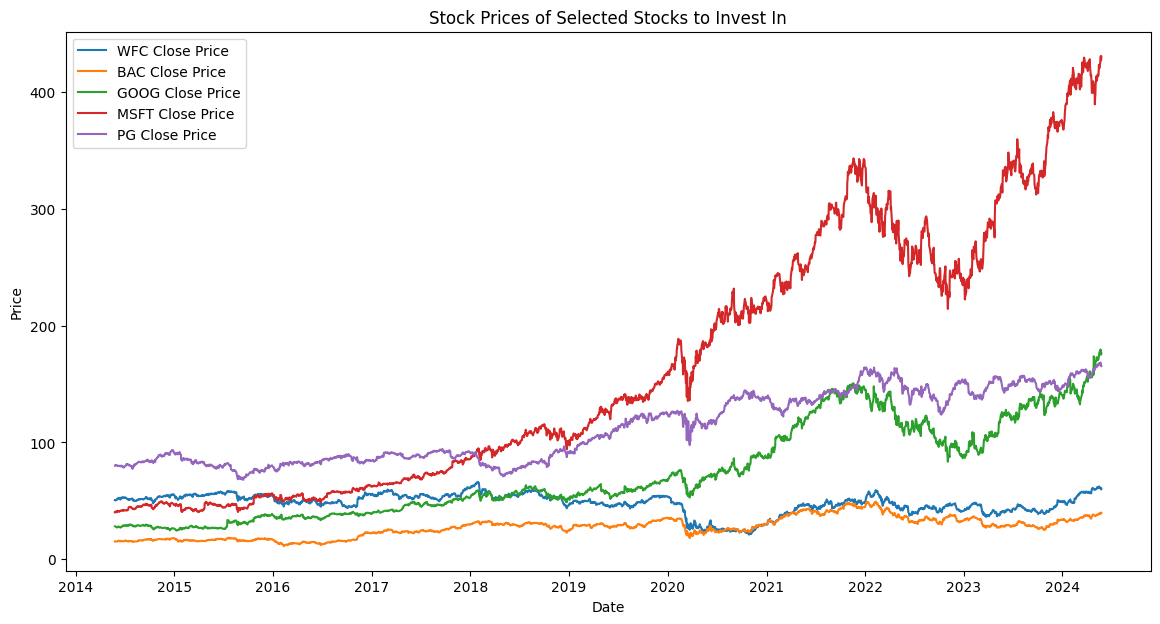

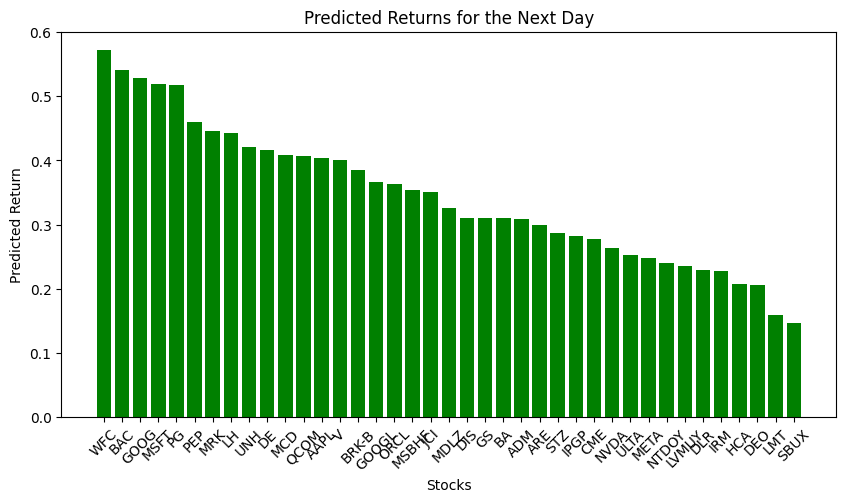

In [5]:
import matplotlib.pyplot as plt

def predict_next_day_return(model, data):
    model.eval()
    last_sequence = data[-seq_length:]
    last_sequence = torch.tensor(last_sequence.values, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(last_sequence)
    return prediction.item()

predicted_returns = {}
for stock, model in models.items():
    predicted_returns[stock] = predict_next_day_return(model, preprocessed_data[stock])

investment_strategy = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
print("Investment Strategy:")
for stock, predicted_return in investment_strategy:
    print(f"Invest in {stock}: Predicted Return = {predicted_return:.4f}")

investment_stocks = [stock for stock, _ in investment_strategy[:5]]  # Choose top 5 stocks to invest in

plt.figure(figsize=(14, 7))

for stock in investment_stocks:
    data = stock_data[stock]
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    plt.plot(data.index, data['Close'], label=f"{stock} Close Price")

plt.title("Stock Prices of Selected Stocks to Invest In")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

predicted_returns_sorted = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
stocks = [stock for stock, _ in predicted_returns_sorted]
returns = [predicted_return for _, predicted_return in predicted_returns_sorted]

plt.bar(stocks, returns, color='green')
plt.title("Predicted Returns for the Next Day")
plt.xlabel("Stocks")
plt.ylabel("Predicted Return")
plt.xticks(rotation=45)
plt.show()

Simulating trading strategy for BA...
Simulating trading strategy for MSBHF...
Simulating trading strategy for V...
Simulating trading strategy for HCA...
Simulating trading strategy for NTDOY...
Simulating trading strategy for ADM...
Simulating trading strategy for LH...
Simulating trading strategy for BAC...
Simulating trading strategy for IRM...
Simulating trading strategy for STZ...
Simulating trading strategy for ULTA...
Simulating trading strategy for ARE...
Simulating trading strategy for PEP...
Simulating trading strategy for MDLZ...
Simulating trading strategy for DLR...
Simulating trading strategy for LVMUY...
Simulating trading strategy for MRK...
Simulating trading strategy for ORCL...
Simulating trading strategy for SBUX...
Simulating trading strategy for IPGP...
Simulating trading strategy for PG...
Simulating trading strategy for MCD...
Simulating trading strategy for DEO...
Simulating trading strategy for MSFT...
Simulating trading strategy for DE...
Simulating trading 

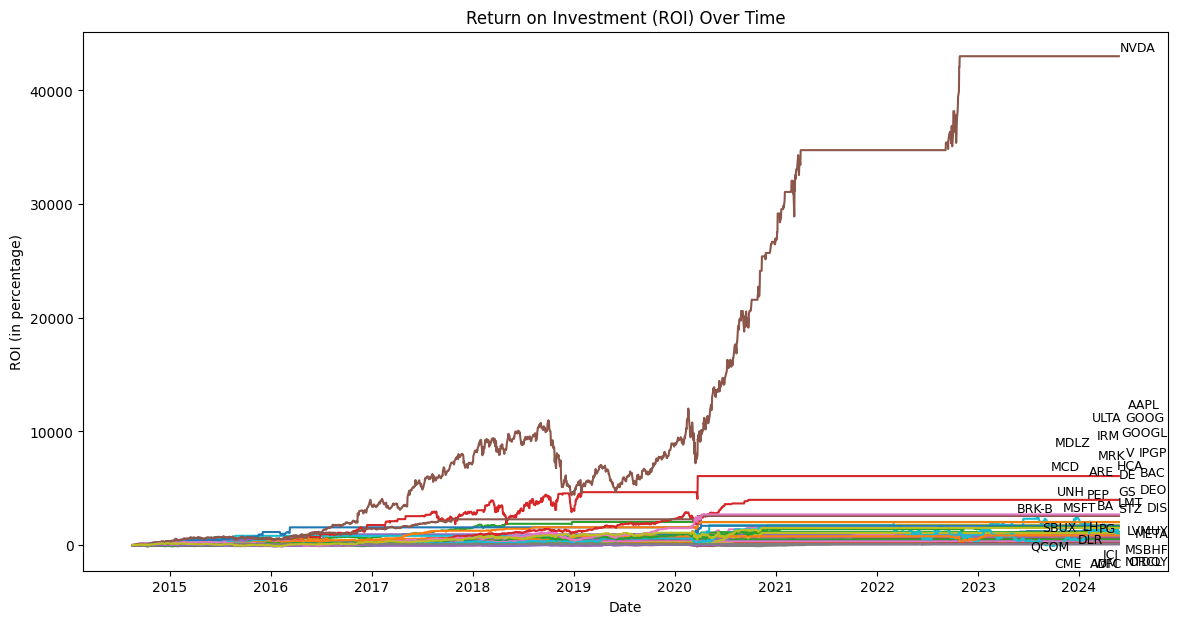

In [16]:
from adjustText import adjust_text

def simulate_trading(model, data, scaler, initial_money=10000):
    model.eval()
    money = initial_money
    stocks_owned = 0
    initial_money_over_time = [initial_money]
    money_over_time = []
    prices = data['Close'].values
    test_sequences, _ = create_sequences(data)
    test_sequences_tensor = to_tensor(test_sequences).to(device)

    with torch.no_grad():
        predictions = model(test_sequences_tensor).cpu().numpy().flatten()

    for i in range(len(predictions)):
        current_price = prices[i + seq_length]
        if current_price == 0:
            money_over_time.append((money - initial_money) / initial_money * 100)
            continue
        predicted_price = predictions[i]
        if predicted_price > current_price:
            # Buy
            stocks_owned += money // current_price
            money %= current_price
        elif predicted_price < current_price and stocks_owned > 0:
            # Sell
            money += stocks_owned * current_price
            stocks_owned = 0
        total_value = money + stocks_owned * current_price
        money_over_time.append((total_value - initial_money) / initial_money * 100)

    return money_over_time

initial_money = 10000
roi_data = {}
date_indices = {}

for stock, model in models.items():
    print(f"Simulating trading strategy for {stock}...")
    scaled_data = preprocessed_data[stock]
    roi_data[stock] = simulate_trading(model, scaled_data, scalers[stock], initial_money)
    date_indices[stock] = scaled_data.index[seq_length:].tolist()

plt.figure(figsize=(14, 7))
texts = []
for stock, roi in roi_data.items():
    plt.plot(date_indices[stock], roi, label=stock)
    texts.append(plt.text(date_indices[stock][-1], roi[-1], stock, fontsize=9))

adjust_text(texts)

plt.title('Return on Investment (ROI) Over Time')
plt.xlabel('Date')
plt.ylabel('ROI (in percentage)')
plt.show()